In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
import optuna
import optuna.visualization as vis

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import accuracy_score  
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBClassifier



from pprint import pprint


# Read The Dataset

In [461]:
# Load datasets
df = pd.read_csv("Surveydata_train_(2).csv")
dftest = pd.read_csv("Surveydata_test_(2).csv")
dftravel = pd.read_csv('Traveldata_train_(2).csv')
dftraveltest = pd.read_csv('Traveldata_test_(2).csv')

# Merge The datasets

In [462]:
train_data = pd.merge(df, dftravel, on='ID', how='inner')
test_data = pd.merge(dftest, dftraveltest, on='ID', how='inner')

In [407]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Overall_Experience       94379 non-null  int64  
 2   Seat_Comfort             94318 non-null  object 
 3   Seat_Class               94379 non-null  object 
 4   Arrival_Time_Convenient  85449 non-null  object 
 5   Catering                 85638 non-null  object 
 6   Platform_Location        94349 non-null  object 
 7   Onboard_Wifi_Service     94349 non-null  object 
 8   Onboard_Entertainment    94361 non-null  object 
 9   Online_Support           94288 non-null  object 
 10  Ease_of_Online_Booking   94306 non-null  object 
 11  Onboard_Service          86778 non-null  object 
 12  Legroom                  94289 non-null  object 
 13  Baggage_Handling         94237 non-null  object 
 14  CheckIn_Service       

# Treat The NULLs

In [385]:
test_data.isnull().sum()

ID                            0
Seat_Comfort                 22
Seat_Class                    0
Arrival_Time_Convenient    3325
Catering                   3357
Platform_Location            12
Onboard_Wifi_Service         12
Onboard_Entertainment         8
Online_Support               26
Ease_of_Online_Booking       18
Onboard_Service            2872
Legroom                      25
Baggage_Handling             40
CheckIn_Service              22
Cleanliness                   2
Online_Boarding               2
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
dtype: int64

In [ ]:
['Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service','Onboard_Entertainment',
'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom' 'Baggage_Handling', 
'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type','Age','Type_Travel','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']



In [23]:
train_data.isnull().sum()

ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64

In [ ]:
columns_to_impute = ['Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service','Onboard_Entertainment',
'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom' 'Baggage_Handling', 
'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type','Age','Type_Travel','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']


Optimize the NULL infill parameters first filling the most gone

In [7]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [ 1650, 1700, 1750, 1800],         # Different number of trees
    'max_depth': [20, 25, 30 ],                # Different depth values
    'min_samples_split': [2],                    # Minimum samples needed to split
    'min_samples_leaf': [1],                      # Minimum samples at each leaf
    'max_features': ['sqrt'],                   # Number of features considered at each split
    'bootstrap': [False]                          # Whether to use bootstrap samples
}

columns_to_impute = [
    'Seat_Comfort', 'Arrival_Time_Convenient', 'Catering', 'Onboard_Service', 
    'Customer_Type', 'Type_Travel'
]

# Iterate over each column to perform RandomizedSearchCV
for column in columns_to_impute:
    print(f"Optimizing RandomForest for column: {column}")
    
    # Separate rows with and without missing values in this column
    non_null_data = train_data[train_data[column].notnull()]
    null_data = train_data[train_data[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]

    # Initialize RandomizedSearchCV with the parameter grid
    model = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,       # Try 10 random combinations; increase if needed
        cv=3,            # 3-fold cross-validation
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Fit RandomizedSearchCV to find the best parameters
    random_search.fit(X_train_encoded, y_train)

    # Output the best parameters for this column
    print(f"Best parameters for {column}: {random_search.best_params_}")
    print("\n" + "="*50 + "\n")

    # Predict and fill missing values using the best estimator
    best_model = random_search.best_estimator_
    train_data.loc[train_data[column].isnull(), column] = best_model.predict(X_null_encoded)


Optimizing RandomForest for column: Seat_Comfort
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Seat_Comfort: {'n_estimators': 1700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


Optimizing RandomForest for column: Arrival_Time_Convenient
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Arrival_Time_Convenient: {'n_estimators': 1700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}


Optimizing RandomForest for column: Catering
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Catering: {'n_estimators': 1650, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


Optimizing RandomForest for column: Onboard_Service
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Onboard_Service: {'n_e

- Seat_Comfort: {'n_estimators': 1700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
- Arrival_Time_Convenient: {'n_estimators': 1700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}
- Catering: {'n_estimators': 1650, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
- Onboard_Service: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}
- Customer_Type: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
- Type_Travel: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}

## Treat those nulls

## Train fill ##

In [408]:
columns_to_impute = ['Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service','Onboard_Entertainment',
'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom', 'Baggage_Handling', 
'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type','Age','Type_Travel','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']



for column in columns_to_impute:
    # Separate rows with and without missing values in this column
    non_null_data = train_data[train_data[column].notnull()]
    null_data = train_data[train_data[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]

    # Determine if the column is categorical or numerical
    if train_data[column].dtype == 'object' or train_data[column].nunique() < 20:
        # Use RandomForestClassifier for categorical data with specified parameters
        model = RandomForestClassifier(
            n_estimators=1715,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            max_depth=47,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        )
    else:
        # Use RandomForestRegressor for numerical data with specified parameters
        model = RandomForestRegressor(
            n_estimators=1715,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            max_depth=47,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        )

    # Train the model to predict the missing values
    model.fit(X_train_encoded, y_train)
    
    # Predict and fill missing values
    train_data.loc[train_data[column].isnull(), column] = model.predict(X_null_encoded)

print("All missing values filled.")

All missing values filled.


## Test fill ##

combine train to test

In [409]:
testhelp = train_data.drop(columns=["Overall_Experience"]).copy()

# Step 2: Append `testhelp` to `test_data`
test_data_extended = pd.concat([test_data, testhelp], ignore_index=True)


Fill Test nulls

In [410]:
columns_to_impute = ['Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service','Onboard_Entertainment',
'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom', 'Baggage_Handling', 
'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type','Age','Type_Travel','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']



for column in columns_to_impute:
    # Separate rows with and without missing values in this column
    non_null_data = test_data_extended[test_data_extended[column].notnull()]
    null_data = test_data_extended[test_data_extended[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]

    # Determine if the column is categorical or numerical
    if test_data_extended[column].dtype == 'object' or test_data_extended[column].nunique() < 20:
        # Use RandomForestClassifier for categorical data with specified parameters
        model = RandomForestClassifier(
            n_estimators=1715,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            max_depth=47,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        )
    else:
        # Use RandomForestRegressor for numerical data with specified parameters
        model = RandomForestRegressor(
            n_estimators=1715,
            min_samples_split=3,
            min_samples_leaf=1,
            max_features='sqrt',
            max_depth=47,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        )

    # Train the model to predict the missing values
    model.fit(X_train_encoded, y_train)
    
    # Predict and fill missing values
    test_data_extended.loc[test_data_extended[column].isnull(), column] = model.predict(X_null_encoded)

print("All missing values filled.")

All missing values filled.


Decouple train from test

In [411]:
test_data_final = test_data_extended.iloc[:len(test_data)].copy()

# Check the result
print("Final test_data after imputing and removing testhelp:")
test_data_final.isnull().sum()  # Confirm no nulls remain

Final test_data after imputing and removing testhelp:


ID                         0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
dtype: int64

---------------------------------------------

In [412]:
df1_sorted = test_data.sort_values(by="ID").reset_index(drop=True)
df2_sorted = test_data_final.sort_values(by="ID").reset_index(drop=True)

if df1_sorted["ID"].equals(df2_sorted["ID"]):
    print("The ID columns are exactly the same in both DataFrames.")
else:
    print("The ID columns differ between the two DataFrames.")

The ID columns are exactly the same in both DataFrames.


In [413]:
trained_data =train_data.copy()
trainedtest_data = test_data_final.copy()

In [414]:
trained_data.info(), trainedtest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Overall_Experience       94379 non-null  int64  
 2   Seat_Comfort             94379 non-null  object 
 3   Seat_Class               94379 non-null  object 
 4   Arrival_Time_Convenient  94379 non-null  object 
 5   Catering                 94379 non-null  object 
 6   Platform_Location        94379 non-null  object 
 7   Onboard_Wifi_Service     94379 non-null  object 
 8   Onboard_Entertainment    94379 non-null  object 
 9   Online_Support           94379 non-null  object 
 10  Ease_of_Online_Booking   94379 non-null  object 
 11  Onboard_Service          94379 non-null  object 
 12  Legroom                  94379 non-null  object 
 13  Baggage_Handling         94379 non-null  object 
 14  CheckIn_Service       

(None, None)

# Split the data

In [415]:
X_train = trained_data.drop(columns=["Overall_Experience"])
y_train = trained_data["Overall_Experience"]

test_ID = trainedtest_data["ID"]
X_test = trainedtest_data.drop(columns=["ID"]) 

combined_data = pd.concat([X_train, X_test], keys=["train", "test"])
combined_data = pd.get_dummies(combined_data)

X_train_encoded = combined_data.loc["train"]
X_test_encoded = combined_data.loc["test"]

X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# **Current Optimized XGBOOST version**|

In [65]:
X_trainxb = trained_data.drop(columns=["Overall_Experience"])
y_trainxb = trained_data["Overall_Experience"]

test_IDxb = trainedtest_data["ID"]
X_testxb = trainedtest_data.drop(columns=["ID"]) 

combined_dataxb = pd.concat([X_trainxb, X_testxb], keys=["train", "test"])
combined_dataxb = pd.get_dummies(combined_dataxb)

X_train_encodedxb = combined_dataxb.loc["train"]
X_test_encodedxb = combined_dataxb.loc["test"]

X_test_encodedxb = X_test_encodedxb.reindex(columns=X_train_encodedxb.columns, fill_value=0)

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',        # Objective for multi-class classification
    num_class=len(y_trainxb.unique()), # Number of unique classes in target
    n_estimators=200,                 # Number of boosting rounds
    learning_rate=0.1,                # Learning rate
    max_depth=6,                      # Maximum depth of each tree
    subsample=0.8,                    # Fraction of samples used per tree
    colsample_bytree=0.8,             # Fraction of features used per tree
    random_state=42
)

# Fit the model on the training data
xgb_model.fit(X_train_encodedxb, y_trainxb)

# Make predictions on the test data
y_predxb = xgb_model.predict(X_test_encodedxb)

# Save predictions with ID to CSV
output_df = pd.DataFrame({"ID": test_IDxb, "Overall_Experience": y_predxb})
output_df.to_csv("xgboost_predictions.csv", index=False)

print("Predictions saved to xgboost_predictions.csv.")

Predictions saved to xgboost_predictions.csv.


# **Current Optimized Random Forest version**


Previous
- 0.9571092
- 0.9571934
- 0.9573619
- 0.9577552
- 0.9578114
- 0.9580642
- 0.9582046

Current
- 0.9586821	

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importance_df)

# Set a threshold for feature importance
threshold = 0.001

# Select features that meet the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

# Filter the training and test sets to keep only selected features
X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]


In [324]:
# Fit the model on the selected features
optimized_model = RandomForestClassifier(
    n_estimators=1600,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=40,
    bootstrap=False,
    random_state=44,
    n_jobs=-1
)

optimized_model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test set
test_predictions = optimized_model.predict(X_test_selected)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)

0.9751

In [188]:
xgb_model = XGBClassifier(
    n_estimators=1251,
    max_depth=54,
    learning_rate=0.018903820840019563,
    subsample=0.88218107610837,
    colsample_bytree=0.6830654733490816,
    gamma=2.340207316588234,
    use_label_encoder=False,  # To avoid label encoding warnings
    eval_metric='logloss'     # Use appropriate evaluation metric for classification
)

# Fit the model on the training data
xgb_model.fit(X_train_encoded, y_train)

# Make predictions on the encoded test set
xgb_test_predictions = xgb_model.predict(X_test_encoded)

# Save predictions to CSV with ID and predicted outcome
xgb_output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": xgb_test_predictions})
xgb_output_df.to_csv("predictions_xgb.csv", index=False)


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:58:47] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Averaging their Predictions

In [200]:
# Build and fit the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1251,
    max_depth=54,
    learning_rate=0.018903820840019563,
    subsample=0.88218107610837,
    colsample_bytree=0.6830654733490816,
    gamma=2.340207316588234,
    use_label_encoder=False,  # To avoid label encoding warnings
    eval_metric='logloss'     # Use appropriate evaluation metric for classification
)

xgb_model.fit(X_train_encoded, y_train)

# Make predictions on the test set with XGBoost
xgb_test_predictions = xgb_model.predict(X_test_encoded)

# Build and fit the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=1715,         # Optimal number of trees
    min_samples_split=2,       # Optimal minimum samples per split
    min_samples_leaf=1,        # Optimal minimum samples per leaf
    max_features='sqrt',       # Optimal maximum features per split
    max_depth=47,              # Optimal maximum depth of the tree
    bootstrap=False,           # Optimal bootstrap setting
    random_state=42,           # Set random_state for reproducibility
    n_jobs=-1
)

rf_model.fit(X_train_encoded, y_train)

# Make predictions on the test set with Random Forest
rf_test_predictions = rf_model.predict(X_test_encoded)

# Average the predictions
# Here we assume that both models predict class labels (0 or 1).
# If you want to predict probabilities, use predict_proba instead.
averaged_predictions = (xgb_test_predictions + rf_test_predictions) / 2
# Convert averaged predictions to binary (0 or 1) based on a threshold (0.5).
final_predictions = (averaged_predictions >= 0.5).astype(int)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": final_predictions})
output_df.to_csv("predictions_averaged.csv", index=False)

print("Averaged predictions saved to 'predictions_averaged.csv'.")


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:38] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Weighted averaged predictions saved to 'predictions_weighted_averaged.csv'.


# Start Optimizing

In [59]:
n_estimators = [1705, 1710, 1715, 1720]
max_features = ['sqrt']
max_depth = [43, 44, 45, 46, 47]
min_samples_split = [2]
min_samples_leaf = [1]
bootstrap = [False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)  # Use RandomForestRegressor if the target variable is continuous

# Random search of parameters, using 3-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


{'bootstrap': [False],
 'max_depth': [43, 44, 45, 46, 47],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [1705, 1710, 1715, 1720]}


In [60]:
# Fit the random search model
rf_random.fit(X_train_encoded, y_train)

# Make predictions on the encoded test set using the best estimator
test_predictions = rf_random.predict(X_test_encoded)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_random_search.csv", index=False)

# Print the top 5 best parameter combinations
results = pd.DataFrame(rf_random.cv_results_)
top_10_results = results.nlargest(5, 'mean_test_score')
top_10_params = top_10_results[['params', 'mean_test_score']]

print("Top 5 Best Parameter Combinations and Scores:")
for i, (params, score) in enumerate(zip(top_10_params['params'], top_10_params['mean_test_score']), 1):
    print(f"{i}: {params}, Score: {score}")

# Print the single best parameters and accuracy score on training set
print("\nBest Parameters:", rf_random.best_params_)
train_predictions = rf_random.predict(X_train_encoded)
print("Training Accuracy Score:", accuracy_score(y_train, train_predictions))

c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Top 5 Best Parameter Combinations and Scores:
1: {'n_estimators': 1705, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 47, 'bootstrap': False}, Score: 0.9596944318152907
2: {'n_estimators': 1715, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 47, 'bootstrap': False}, Score: 0.9596414544895862
3: {'n_estimators': 1720, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 47, 'bootstrap': False}, Score: 0.9596202624365466
4: {'n_estimators': 1710, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 47, 'bootstrap': False}, Score: 0.9596202613137887
5: {'n_estimators': 1710, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 44, 'bootstrap': False}, Score: 0.9595778816987407

Best Parameters: {'n_estimators': 1705, 'min_samples_split': 2, 'min_samples_leaf': 1

# Test Optimizer

In [138]:
model = RandomForestClassifier(
    n_estimators=1705,         # Optimal number of trees
    min_samples_split=2,       # Optimal minimum samples per split
    min_samples_leaf=1,        # Optimal minimum samples per leaf
    max_features='sqrt',       # Optimal maximum features per split
    max_depth=47,              # Optimal maximum depth of the tree
    bootstrap=False,           # Optimal bootstrap setting
    random_state=42,            # Set random_state for reproducibility
    n_jobs=-1
)

# Fit the model on the training data
model.fit(X_train_encoded, y_train)

# Make predictions on the encoded test set
test_predictions = model.predict(X_test_encoded)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)

In [243]:
test_IDop = trainedtest_data["ID"]
X_testop = trainedtest_data.drop(columns=["ID"]) 

In [244]:
X_trainop = trained_data.drop(columns=["Overall_Experience"])
y_trainop = trained_data["Overall_Experience"]

X_trainop = pd.get_dummies(X_trainop)

In [245]:
X_traino, X_testo, y_traino, y_testo = train_test_split(X_trainop, y_trainop, test_size=0.2, random_state=42)


In [246]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)

In [247]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)

In [248]:
xgb.fit(X_traino, y_traino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [249]:
y_pred = xgb.predict(X_testo)

In [250]:
mean_absolute_error(y_testo,y_pred)

0.041110404746768386

In [251]:
mean_squared_error(y_testo,y_pred)

0.041110404746768386

In [252]:
r2_score(y_testo,y_pred)

0.8335645584351239

#Optuna

In [253]:
from sklearn.model_selection import cross_val_score

In [257]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 1000, 2500)  # Adjust range as needed
    max_depth = trial.suggest_int('max_depth', 40, 100)  # Adjust range as needed
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Typical range
    subsample = trial.suggest_float('subsample', 0.1, 1.0)  # Proportion of samples
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)  # Proportion of features
    gamma = trial.suggest_float('gamma', 0, 10)  # Regularization term

    # Initialize the model
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        use_label_encoder=False,  # To avoid label encoding warnings
        eval_metric='rmse'
    )

    # Perform cross-validation and return the mean score
    score = cross_val_score(model, X_train_encoded, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return float(score.mean())  # Convert the mean score to a float


In [232]:
study = optuna.create_study(direction='maximize')

[I 2024-10-29 00:09:01,822] A new study created in memory with name: no-name-42e91331-7691-42ce-96bd-f8279e51d63f


In [259]:
study.optimize(objective, n_trials=1000)

[I 2024-10-29 00:15:28,751] Trial 13 finished with value: 0.9568124383743889 and parameters: {'n_estimators': 1046, 'max_depth': 98, 'learning_rate': 0.18452159703667861, 'subsample': 0.6190739228387588, 'colsample_bytree': 0.8035989957597978, 'gamma': 7.7752887547067076}. Best is trial 5 with value: 0.9593341658141176.
[I 2024-10-29 00:15:41,863] Trial 14 finished with value: 0.9554773676654472 and parameters: {'n_estimators': 1878, 'max_depth': 97, 'learning_rate': 0.09698704939540954, 'subsample': 0.29340912455734935, 'colsample_bytree': 0.8248393557609789, 'gamma': 4.730518871366167}. Best is trial 5 with value: 0.9593341658141176.
[I 2024-10-29 00:15:55,561] Trial 15 finished with value: 0.9499464602024507 and parameters: {'n_estimators': 2217, 'max_depth': 48, 'learning_rate': 0.2836354698103937, 'subsample': 0.21278574571058775, 'colsample_bytree': 0.7279730003776861, 'gamma': 8.663017089129983}. Best is trial 5 with value: 0.9593341658141176.
[I 2024-10-29 00:16:03,924] Trial 1

In [260]:
study.best_params

{'n_estimators': 1418,
 'max_depth': 82,
 'learning_rate': 0.010080612029979666,
 'subsample': 0.9842558462315757,
 'colsample_bytree': 0.5457711506096025,
 'gamma': 0.7633202787578363}

In [217]:
best_params = study.best_params

In [262]:
import optuna.visualization as vis


In [269]:
vis.plot_optimization_history(study).show()


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [273]:
model = RandomForestClassifier(
    n_estimators=1715,         # Optimal number of trees
    min_samples_split=2,       # Optimal minimum samples per split
    min_samples_leaf=1,        # Optimal minimum samples per leaf
    max_features='sqrt',       # Optimal maximum features per split
    max_depth=47,              # Optimal maximum depth of the tree
    bootstrap=False,           # Optimal bootstrap setting
    random_state=44,            # Set random_state for reproducibility
    n_jobs=-1
)

# Fit the model on the training data
model.fit(X_train_encoded, y_train)

# Make predictions on the encoded test set
test_predictions = model.predict(X_test_encoded)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)

# Neural Network

In [325]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [326]:
trained_data = train_data.copy()
trainedtest_data = test_data_final.copy()

In [327]:
X_train = trained_data.drop(columns=["Overall_Experience"])
y_train = trained_data["Overall_Experience"]

# Preparing test data
test_ID = trainedtest_data["ID"]
X_test = trainedtest_data.drop(columns=["ID"])

# Combine train and test data for consistent preprocessing
combined_data = pd.concat([X_train, X_test], keys=["train", "test"])
combined_data = pd.get_dummies(combined_data)  # One-hot encoding

# Split back into train and test
X_train_encoded = combined_data.loc["train"]
X_test_encoded = combined_data.loc["test"]

# Ensure the test set has the same columns as the train set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)  # Convert to tensor
X_test_tensor = torch.FloatTensor(X_test_scaled)

In [332]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [338]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_layers=5, num_units=64):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(X_train_scaled.shape[1], num_units))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(num_units, num_units))
        
        # Output layer
        self.layers.append(nn.Linear(num_units, 1))
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        for layer in self.layers[:-1]:  # Iterate over hidden layers
            x = torch.relu(layer(x))
            x = self.dropout(x)
        return torch.sigmoid(self.layers[-1](x))  # Final layer with sigmoid

# Prepare training data
X_train = trained_data.drop(columns=["Overall_Experience"])
y_train = trained_data["Overall_Experience"].astype(float)  # Ensure float type

# Prepare test data
test_ID = trainedtest_data["ID"]
X_test = trainedtest_data.drop(columns=["ID"])

# Combine train and test data for consistent preprocessing
combined_data = pd.concat([X_train, X_test], keys=["train", "test"])
combined_data = pd.get_dummies(combined_data)  # One-hot encoding

# Split back into train and test
X_train_encoded = combined_data.loc["train"]
X_test_encoded = combined_data.loc["test"]

# Ensure the test set has the same columns as the train set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)  # Convert to tensor
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Instantiate the model, define loss and optimizer
model = NeuralNetwork()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)  # Adjust num_workers based on your CPU cores
# Train the model
num_epochs = 200  # Adjust based on validation
for epoch in range(num_epochs):
    model.train()  # Set to training mode
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients

        outputs = model(inputs).squeeze()  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_train_tensor).squeeze()
        val_predictions = (val_outputs >= 0.5).float()
        accuracy = (val_predictions == y_train_tensor).float().mean()

    if (epoch + 1) % 100 == 0:  # Print every 100 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

# After training, make predictions on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary predictions

# Save predictions to CSV
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions.numpy()})
output_df.to_csv("predictions_nn_pytorch.csv", index=False)

print("Predictions saved to 'predictions_nn_pytorch.csv'.")


Epoch [100/200], Loss: 0.1909, Accuracy: 0.9533


KeyboardInterrupt: 

                                    Feature    Importance
38          Onboard_Entertainment_Excellent  7.268869e-02
6                    Seat_Comfort_Excellent  5.369953e-02
37         Onboard_Entertainment_Acceptable  3.760090e-02
41  Onboard_Entertainment_Needs Improvement  2.897151e-02
93             Customer_Type_Loyal Customer  2.843967e-02
..                                      ...           ...
30      Platform_Location_Very Inconvenient  1.608604e-05
80               Cleanliness_Extremely Poor  3.324167e-06
57           Onboard_Service_Extremely Poor  2.938733e-06
74           CheckIn_Service_Extremely Poor  1.128816e-06
45            Online_Support_Extremely Poor  9.584494e-07

[98 rows x 2 columns]


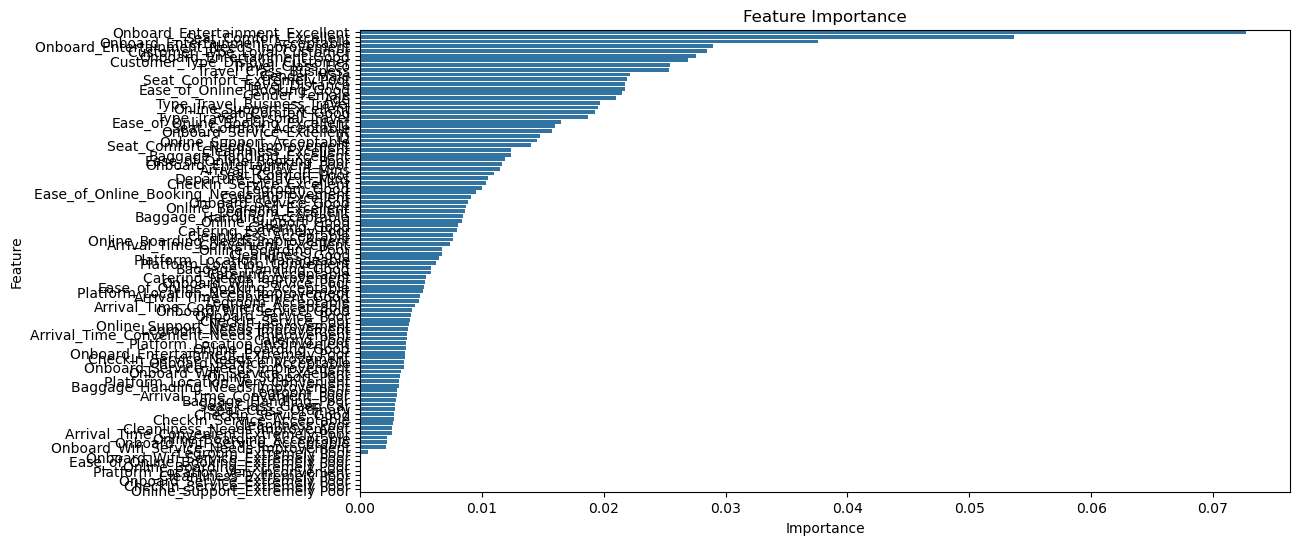

In [437]:
# Fit the model on the selected features
optimized_model = RandomForestClassifier(
    n_estimators=1600,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=40,
    bootstrap=False,
    random_state=44,
    n_jobs=-1
)

optimized_model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test set
test_predictions = optimized_model.predict(X_test_selected)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)


# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importance_df)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()



In [423]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importance_df)

# Set a threshold for feature importance
threshold = 0.001

# Select features that meet the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

# Filter the training and test sets to keep only selected features
X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]


                                    Feature    Importance
38          Onboard_Entertainment_Excellent  7.268869e-02
6                    Seat_Comfort_Excellent  5.369953e-02
37         Onboard_Entertainment_Acceptable  3.760090e-02
41  Onboard_Entertainment_Needs Improvement  2.897151e-02
93             Customer_Type_Loyal Customer  2.843967e-02
..                                      ...           ...
30      Platform_Location_Very Inconvenient  1.608604e-05
80               Cleanliness_Extremely Poor  3.324167e-06
57           Onboard_Service_Extremely Poor  2.938733e-06
74           CheckIn_Service_Extremely Poor  1.128816e-06
45            Online_Support_Extremely Poor  9.584494e-07

[98 rows x 2 columns]


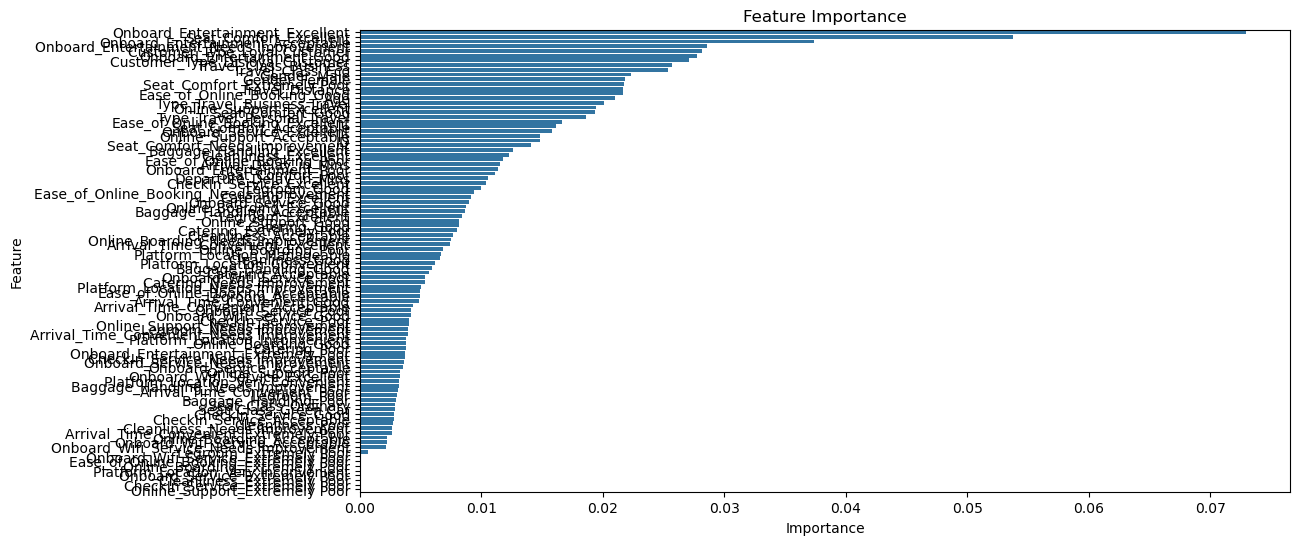

In [418]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()


Current Best
- 0.9587102 threshold = 0.001

In [446]:
# Set a threshold for feature importance
threshold = 0.001
# Select features that meet the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

# Filter the training and test sets to keep only selected features
X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]


In [447]:
# Fit the model on the selected features
optimized_model = RandomForestClassifier(
    n_estimators=1600,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=40,
    bootstrap=False,
    random_state=44,
    n_jobs=-1
)

optimized_model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test set
test_predictions = optimized_model.predict(X_test_selected)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)


Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [435]:
# Define the parameter grid
param_grid = {
    'n_estimators': [1400, 1500, 1600],
    'max_depth': [35 ,40, 65],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

# Initialize the model
rf = RandomForestClassifier(random_state=44, n_jobs=-1)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_encoded, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validated score:", best_score)

# Train the model with the best parameters
optimized_model = RandomForestClassifier(**best_params, random_state=44, n_jobs=-1)
optimized_model.fit(X_train_encoded, y_train)

# Make predictions on the encoded test set
test_predictions = optimized_model.predict(X_test_encoded)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1600}
Best cross-validated score: 0.9587090328094542


In [436]:
# Fit the model on the selected features
optimized_model = RandomForestClassifier(
    n_estimators=1600,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=40,
    bootstrap=False,
    random_state=44,
    n_jobs=-1
)

optimized_model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test set
test_predictions = optimized_model.predict(X_test_selected)

# Save predictions to CSV with ID and predicted outcome
output_df = pd.DataFrame({"ID": test_ID, "Overall_Experience": test_predictions})
output_df.to_csv("predictions_rf_optimized.csv", index=False)


Grid Search the NULLs


In [ ]:
columns_to_impute = ['Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service','Onboard_Entertainment',
'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom', 'Baggage_Handling', 
'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type','Age','Type_Travel','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']



for column in columns_to_impute:
    # Separate rows with and without missing values in this column
    non_null_data = train_data[train_data[column].notnull()]
    null_data = train_data[train_data[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]

    # Determine if the column is categorical or numerical
    if train_data[column].dtype == 'object' or train_data[column].nunique() < 20:
        # Use RandomForestClassifier for categorical data with specified parameters
        model = RandomForestClassifier(
            n_estimators=1715,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            max_depth=47,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        )
    else:
        # Use RandomForestRegressor for numerical data with specified parameters
        model = RandomForestRegressor(
            n_estimators=1715,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            max_depth=47,
            bootstrap=False,
            random_state=42,
            n_jobs=-1
        )

    # Train the model to predict the missing values
    model.fit(X_train_encoded, y_train)
    
    # Predict and fill missing values
    train_data.loc[train_data[column].isnull(), column] = model.predict(X_null_encoded)

print("All missing values filled.")

In [452]:
train_data = pd.merge(df, dftravel, on='ID', how='inner')
test_data = pd.merge(dftest, dftraveltest, on='ID', how='inner')

In [450]:
columns_to_impute = [
    'Seat_Comfort','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service',
    'Onboard_Entertainment', 'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom', 
    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type',
    'Age', 'Type_Travel', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'
]

# Define parameter grids for classifier and regressor
param_grid_classifier = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

param_grid_regressor = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Dictionary to store best results
best_results = {}

for column in columns_to_impute:
    # Separate rows with and without missing values in this column
    non_null_data = train_data[train_data[column].notnull()]
    null_data = train_data[train_data[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]

    # Determine if the column is categorical or numerical
    if train_data[column].dtype == 'object' or train_data[column].nunique() < 20:
        # Use RandomForestClassifier with Grid Search for categorical data
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_classifier,
                                   cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
    else:
        # Use RandomForestRegressor with Grid Search for numerical data
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_regressor,
                                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

    # Fit grid search on training data
    grid_search.fit(X_train_encoded, y_train)
    
    # Store best parameters and score in the results dictionary
    best_results[column] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Output the best parameters and scores for each variable
for column, result in best_results.items():
    print(f"Column: {column}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Score: {result['best_score']}")
    print("-" * 30)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Column: Seat_Comfort
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.9197820264971296
------------------------------
Column: Arrival_Time_Convenient
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.7656730915516858
------------------------------
Column: Catering
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: 0.89

In [455]:
train_data = pd.merge(df, dftravel, on='ID', how='inner')
test_data = pd.merge(dftest, dftraveltest, on='ID', how='inner')

In [457]:
train_data.isnull().sum()


ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer

# Define best parameters for each column
best_params = {
    'Seat_Comfort': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Arrival_Time_Convenient': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Catering': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Platform_Location': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Onboard_Wifi_Service': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Onboard_Entertainment': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Online_Support': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Ease_of_Online_Booking': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Onboard_Service': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Legroom': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000},
    'Baggage_Handling': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Cleanliness': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Online_Boarding': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Gender': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Customer_Type': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500},
    'Type_Travel': {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
}

columns_to_impute = ['Seat_Comfort', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 
                     'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 
                     'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 
                     'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type', 
                     'Age', 'Type_Travel', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins']

for column in columns_to_impute:
    # Separate rows with and without missing values in this column
    non_null_data = train_data[train_data[column].notnull()]
    null_data = train_data[train_data[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]
    X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

    if column in best_params:
        params = best_params[column]
        if train_data[column].dtype == 'object' or train_data[column].nunique() < 20:
            # Use RandomForestClassifier for categorical data
            model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        else:
            # Use RandomForestRegressor for numerical data
            model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)

        # Train the model to predict the missing values
        model.fit(X_train_encoded, y_train)

        # Predict and fill missing values
        train_data.loc[train_data[column].isnull(), column] = model.predict(X_null_encoded)
    else:
        # For columns not in best_params, use the mode to fill missing values
        imputer = SimpleImputer(strategy='most_frequent')
        train_data[column] = imputer.fit_transform(train_data[[column]])

print("All missing values filled using optimized models or mode.")


In [463]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer

# Seat_Comfort
non_null_data = train_data[train_data['Seat_Comfort'].notnull()]
null_data = train_data[train_data['Seat_Comfort'].isnull()]
X_train = non_null_data.drop(columns=['Seat_Comfort'])
y_train = non_null_data['Seat_Comfort']
X_null = null_data.drop(columns=['Seat_Comfort'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Seat_Comfort'].isnull(), 'Seat_Comfort'] = model.predict(X_null_encoded)

# Arrival_Time_Convenient
non_null_data = train_data[train_data['Arrival_Time_Convenient'].notnull()]
null_data = train_data[train_data['Arrival_Time_Convenient'].isnull()]
X_train = non_null_data.drop(columns=['Arrival_Time_Convenient'])
y_train = non_null_data['Arrival_Time_Convenient']
X_null = null_data.drop(columns=['Arrival_Time_Convenient'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Arrival_Time_Convenient'].isnull(), 'Arrival_Time_Convenient'] = model.predict(X_null_encoded)

# Catering
non_null_data = train_data[train_data['Catering'].notnull()]
null_data = train_data[train_data['Catering'].isnull()]
X_train = non_null_data.drop(columns=['Catering'])
y_train = non_null_data['Catering']
X_null = null_data.drop(columns=['Catering'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Catering'].isnull(), 'Catering'] = model.predict(X_null_encoded)

# Platform_Location
non_null_data = train_data[train_data['Platform_Location'].notnull()]
null_data = train_data[train_data['Platform_Location'].isnull()]
X_train = non_null_data.drop(columns=['Platform_Location'])
y_train = non_null_data['Platform_Location']
X_null = null_data.drop(columns=['Platform_Location'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Platform_Location'].isnull(), 'Platform_Location'] = model.predict(X_null_encoded)

# Onboard_Wifi_Service
non_null_data = train_data[train_data['Onboard_Wifi_Service'].notnull()]
null_data = train_data[train_data['Onboard_Wifi_Service'].isnull()]
X_train = non_null_data.drop(columns=['Onboard_Wifi_Service'])
y_train = non_null_data['Onboard_Wifi_Service']
X_null = null_data.drop(columns=['Onboard_Wifi_Service'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Onboard_Wifi_Service'].isnull(), 'Onboard_Wifi_Service'] = model.predict(X_null_encoded)

# Continue in a similar fashion for each remaining column...


In [464]:
# Onboard_Entertainment
non_null_data = train_data[train_data['Onboard_Entertainment'].notnull()]
null_data = train_data[train_data['Onboard_Entertainment'].isnull()]
X_train = non_null_data.drop(columns=['Onboard_Entertainment'])
y_train = non_null_data['Onboard_Entertainment']
X_null = null_data.drop(columns=['Onboard_Entertainment'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Onboard_Entertainment'].isnull(), 'Onboard_Entertainment'] = model.predict(X_null_encoded)

# Online_Support
non_null_data = train_data[train_data['Online_Support'].notnull()]
null_data = train_data[train_data['Online_Support'].isnull()]
X_train = non_null_data.drop(columns=['Online_Support'])
y_train = non_null_data['Online_Support']
X_null = null_data.drop(columns=['Online_Support'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Online_Support'].isnull(), 'Online_Support'] = model.predict(X_null_encoded)

# Ease_of_Online_Booking
non_null_data = train_data[train_data['Ease_of_Online_Booking'].notnull()]
null_data = train_data[train_data['Ease_of_Online_Booking'].isnull()]
X_train = non_null_data.drop(columns=['Ease_of_Online_Booking'])
y_train = non_null_data['Ease_of_Online_Booking']
X_null = null_data.drop(columns=['Ease_of_Online_Booking'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Ease_of_Online_Booking'].isnull(), 'Ease_of_Online_Booking'] = model.predict(X_null_encoded)

# Onboard_Service
non_null_data = train_data[train_data['Onboard_Service'].notnull()]
null_data = train_data[train_data['Onboard_Service'].isnull()]
X_train = non_null_data.drop(columns=['Onboard_Service'])
y_train = non_null_data['Onboard_Service']
X_null = null_data.drop(columns=['Onboard_Service'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Onboard_Service'].isnull(), 'Onboard_Service'] = model.predict(X_null_encoded)

# Legroom
non_null_data = train_data[train_data['Legroom'].notnull()]
null_data = train_data[train_data['Legroom'].isnull()]
X_train = non_null_data.drop(columns=['Legroom'])
y_train = non_null_data['Legroom']
X_null = null_data.drop(columns=['Legroom'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Legroom'].isnull(), 'Legroom'] = model.predict(X_null_encoded)

# Baggage_Handling
non_null_data = train_data[train_data['Baggage_Handling'].notnull()]
null_data = train_data[train_data['Baggage_Handling'].isnull()]
X_train = non_null_data.drop(columns=['Baggage_Handling'])
y_train = non_null_data['Baggage_Handling']
X_null = null_data.drop(columns=['Baggage_Handling'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Baggage_Handling'].isnull(), 'Baggage_Handling'] = model.predict(X_null_encoded)

# Cleanliness
non_null_data = train_data[train_data['Cleanliness'].notnull()]
null_data = train_data[train_data['Cleanliness'].isnull()]
X_train = non_null_data.drop(columns=['Cleanliness'])
y_train = non_null_data['Cleanliness']
X_null = null_data.drop(columns=['Cleanliness'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Cleanliness'].isnull(), 'Cleanliness'] = model.predict(X_null_encoded)

# Online_Boarding
non_null_data = train_data[train_data['Online_Boarding'].notnull()]
null_data = train_data[train_data['Online_Boarding'].isnull()]
X_train = non_null_data.drop(columns=['Online_Boarding'])
y_train = non_null_data['Online_Boarding']
X_null = null_data.drop(columns=['Online_Boarding'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Online_Boarding'].isnull(), 'Online_Boarding'] = model.predict(X_null_encoded)

# Gender
non_null_data = train_data[train_data['Gender'].notnull()]
null_data = train_data[train_data['Gender'].isnull()]
X_train = non_null_data.drop(columns=['Gender'])
y_train = non_null_data['Gender']
X_null = null_data.drop(columns=['Gender'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
train_data.loc[train_data['Gender'].isnull(), 'Gender'] = model.predict(X_null_encoded)


In [466]:
# Customer_Type
non_null_data = train_data[train_data['Customer_Type'].notnull()]
null_data = train_data[train_data['Customer_Type'].isnull()]

X_train = non_null_data.drop(columns=['Customer_Type'])
y_train = non_null_data['Customer_Type']
X_null = null_data.drop(columns=['Customer_Type'])

# Combine for one-hot encoding
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)

# Split back into encoded training and null sets
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Use RandomForestClassifier with specified parameters
model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_encoded, y_train)

# Predict and fill missing values in Customer_Type
train_data.loc[train_data['Customer_Type'].isnull(), 'Customer_Type'] = model.predict(X_null_encoded)

print("Missing values for 'Customer_Type' filled.")

# Type_Travel
non_null_data = train_data[train_data['Type_Travel'].notnull()]
null_data = train_data[train_data['Type_Travel'].isnull()]

X_train = non_null_data.drop(columns=['Type_Travel'])
y_train = non_null_data['Type_Travel']
X_null = null_data.drop(columns=['Type_Travel'])

# Combine for one-hot encoding
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)

# Split back into encoded training and null sets
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Use RandomForestClassifier with specified parameters
model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_encoded, y_train)

# Predict and fill missing values in Type_Travel
train_data.loc[train_data['Type_Travel'].isnull(), 'Type_Travel'] = model.predict(X_null_encoded)

print("Missing values for 'Type_Travel' filled.")


Missing values for 'Customer_Type' filled.
Missing values for 'Type_Travel' filled.


In [468]:
# Fill nulls with the mode for CheckIn_Service
train_data['CheckIn_Service'].fillna(train_data['CheckIn_Service'].mode()[0], inplace=True)
print("Missing values for 'CheckIn_Service' filled with mode.")

# Fill nulls with the mode for Age
train_data['Age'].fillna(train_data['Age'].mode()[0], inplace=True)
print("Missing values for 'Age' filled with mode.")

# Fill nulls with the mode for Departure_Delay_in_Mins
train_data['Departure_Delay_in_Mins'].fillna(train_data['Departure_Delay_in_Mins'].mode()[0], inplace=True)
print("Missing values for 'Departure_Delay_in_Mins' filled with mode.")

# Fill nulls with the mode for Arrival_Delay_in_Mins
train_data['Arrival_Delay_in_Mins'].fillna(train_data['Arrival_Delay_in_Mins'].mode()[0], inplace=True)
print("Missing values for 'Arrival_Delay_in_Mins' filled with mode.")


Missing values for 'CheckIn_Service' filled with mode.
Missing values for 'Age' filled with mode.
Missing values for 'Departure_Delay_in_Mins' filled with mode.
Missing values for 'Arrival_Delay_in_Mins' filled with mode.


C:\Users\Matthew\AppData\Local\Temp\ipykernel_25416\638394021.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['CheckIn_Service'].fillna(train_data['CheckIn_Service'].mode()[0], inplace=True)
C:\Users\Matthew\AppData\Local\Temp\ipykernel_25416\638394021.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [469]:
train_data.isnull().sum()

ID                         0
Overall_Experience         0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
dtype: int64

In [478]:
testhelp = train_data.drop(columns=["Overall_Experience"]).copy()

# Step 2: Append `testhelp` to `test_data`
test_data_extended = pd.concat([test_data, testhelp], ignore_index=True)

test_data_extended.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129981 entries, 0 to 129980
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       129981 non-null  int64  
 1   Seat_Comfort             129959 non-null  object 
 2   Seat_Class               129981 non-null  object 
 3   Arrival_Time_Convenient  126656 non-null  object 
 4   Catering                 126624 non-null  object 
 5   Platform_Location        129969 non-null  object 
 6   Onboard_Wifi_Service     129969 non-null  object 
 7   Onboard_Entertainment    129973 non-null  object 
 8   Online_Support           129955 non-null  object 
 9   Ease_of_Online_Booking   129963 non-null  object 
 10  Onboard_Service          127109 non-null  object 
 11  Legroom                  129956 non-null  object 
 12  Baggage_Handling         129941 non-null  object 
 13  CheckIn_Service          129959 non-null  object 
 14  Clea

In [479]:
test_data_extended.isnull().sum()

ID                            0
Seat_Comfort                 22
Seat_Class                    0
Arrival_Time_Convenient    3325
Catering                   3357
Platform_Location            12
Onboard_Wifi_Service         12
Onboard_Entertainment         8
Online_Support               26
Ease_of_Online_Booking       18
Onboard_Service            2872
Legroom                      25
Baggage_Handling             40
CheckIn_Service              22
Cleanliness                   2
Online_Boarding               2
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
dtype: int64

In [480]:
columns_to_impute = [
    'Seat_Comfort','Seat_Class','Arrival_Time_Convenient','Catering','Platform_Location','Onboard_Wifi_Service',
    'Onboard_Entertainment', 'Online_Support','Ease_of_Online_Booking','Onboard_Service','Legroom', 
    'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Gender', 'Customer_Type',
    'Age', 'Type_Travel', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins'
]

# Define parameter grids for classifier and regressor
param_grid_classifier = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

param_grid_regressor = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Dictionary to store best results
best_results = {}

for column in columns_to_impute:
    # Separate rows with and without missing values in this column
    non_null_data = test_data_extended[test_data_extended[column].notnull()]
    null_data = test_data_extended[test_data_extended[column].isnull()]

    if null_data.empty:  # Skip if no missing values
        continue

    # Define X and y for training the imputation model
    X_train = non_null_data.drop(columns=[column])
    y_train = non_null_data[column]
    X_null = null_data.drop(columns=[column])

    # One-hot encode categorical columns
    combined_data = pd.concat([X_train, X_null], axis=0)
    combined_data = pd.get_dummies(combined_data, drop_first=True)

    # Split encoded data back into training and null sets
    X_train_encoded = combined_data.iloc[:len(X_train), :]
    X_null_encoded = combined_data.iloc[len(X_train):, :]

    # Determine if the column is categorical or numerical
    if test_data_extended[column].dtype == 'object' or test_data_extended[column].nunique() < 20:
        # Use RandomForestClassifier with Grid Search for categorical data
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_classifier,
                                   cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
    else:
        # Use RandomForestRegressor with Grid Search for numerical data
        model = RandomForestRegressor(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_regressor,
                                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

    # Fit grid search on training data
    grid_search.fit(X_train_encoded, y_train)
    
    # Store best parameters and score in the results dictionary
    best_results[column] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Output the best parameters and scores for each variable
for column, result in best_results.items():
    print(f"Column: {column}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Score: {result['best_score']}")
    print("-" * 30)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\Matthew\anaconda3\envs\DeepLearning\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Column: Seat_Comfort
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.9010842392352933
------------------------------
Column: Arrival_Time_Convenient
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: 0.7794736049653913
------------------------------
Column: Catering
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: 0.9

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer

# Seat_Comfort
non_null_data = test_data_extended[test_data_extended['Seat_Comfort'].notnull()]
null_data = test_data_extended[test_data_extended['Seat_Comfort'].isnull()]
X_train = non_null_data.drop(columns=['Seat_Comfort'])
y_train = non_null_data['Seat_Comfort']
X_null = null_data.drop(columns=['Seat_Comfort'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Seat_Comfort'].isnull(), 'Seat_Comfort'] = model.predict(X_null_encoded)

# Arrival_Time_Convenient
non_null_data = test_data_extended[test_data_extended['Arrival_Time_Convenient'].notnull()]
null_data = test_data_extended[test_data_extended['Arrival_Time_Convenient'].isnull()]
X_train = non_null_data.drop(columns=['Arrival_Time_Convenient'])
y_train = non_null_data['Arrival_Time_Convenient']
X_null = null_data.drop(columns=['Arrival_Time_Convenient'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Arrival_Time_Convenient'].isnull(), 'Arrival_Time_Convenient'] = model.predict(X_null_encoded)

# Catering
non_null_data = test_data_extended[test_data_extended['Catering'].notnull()]
null_data = test_data_extended[test_data_extended['Catering'].isnull()]
X_train = non_null_data.drop(columns=['Catering'])
y_train = non_null_data['Catering']
X_null = null_data.drop(columns=['Catering'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Catering'].isnull(), 'Catering'] = model.predict(X_null_encoded)

# Platform_Location
non_null_data = test_data_extended[test_data_extended['Platform_Location'].notnull()]
null_data = test_data_extended[test_data_extended['Platform_Location'].isnull()]
X_train = non_null_data.drop(columns=['Platform_Location'])
y_train = non_null_data['Platform_Location']
X_null = null_data.drop(columns=['Platform_Location'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Platform_Location'].isnull(), 'Platform_Location'] = model.predict(X_null_encoded)

# Onboard_Wifi_Service
non_null_data = test_data_extended[test_data_extended['Onboard_Wifi_Service'].notnull()]
null_data = test_data_extended[test_data_extended['Onboard_Wifi_Service'].isnull()]
X_train = non_null_data.drop(columns=['Onboard_Wifi_Service'])
y_train = non_null_data['Onboard_Wifi_Service']
X_null = null_data.drop(columns=['Onboard_Wifi_Service'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Onboard_Wifi_Service'].isnull(), 'Onboard_Wifi_Service'] = model.predict(X_null_encoded)

# Continue in a similar fashion for each remaining column...


# Onboard_Entertainment
non_null_data = test_data_extended[test_data_extended['Onboard_Entertainment'].notnull()]
null_data = test_data_extended[test_data_extended['Onboard_Entertainment'].isnull()]
X_train = non_null_data.drop(columns=['Onboard_Entertainment'])
y_train = non_null_data['Onboard_Entertainment']
X_null = null_data.drop(columns=['Onboard_Entertainment'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Onboard_Entertainment'].isnull(), 'Onboard_Entertainment'] = model.predict(X_null_encoded)

# Online_Support
non_null_data = test_data_extended[test_data_extended['Online_Support'].notnull()]
null_data = test_data_extended[test_data_extended['Online_Support'].isnull()]
X_train = non_null_data.drop(columns=['Online_Support'])
y_train = non_null_data['Online_Support']
X_null = null_data.drop(columns=['Online_Support'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Online_Support'].isnull(), 'Online_Support'] = model.predict(X_null_encoded)

# Ease_of_Online_Booking
non_null_data = test_data_extended[test_data_extended['Ease_of_Online_Booking'].notnull()]
null_data = test_data_extended[test_data_extended['Ease_of_Online_Booking'].isnull()]
X_train = non_null_data.drop(columns=['Ease_of_Online_Booking'])
y_train = non_null_data['Ease_of_Online_Booking']
X_null = null_data.drop(columns=['Ease_of_Online_Booking'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Ease_of_Online_Booking'].isnull(), 'Ease_of_Online_Booking'] = model.predict(X_null_encoded)

# Onboard_Service
non_null_data = test_data_extended[test_data_extended['Onboard_Service'].notnull()]
null_data = test_data_extended[test_data_extended['Onboard_Service'].isnull()]
X_train = non_null_data.drop(columns=['Onboard_Service'])
y_train = non_null_data['Onboard_Service']
X_null = null_data.drop(columns=['Onboard_Service'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Onboard_Service'].isnull(), 'Onboard_Service'] = model.predict(X_null_encoded)

# Legroom
non_null_data = test_data_extended[test_data_extended['Legroom'].notnull()]
null_data = test_data_extended[test_data_extended['Legroom'].isnull()]
X_train = non_null_data.drop(columns=['Legroom'])
y_train = non_null_data['Legroom']
X_null = null_data.drop(columns=['Legroom'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Legroom'].isnull(), 'Legroom'] = model.predict(X_null_encoded)

# Baggage_Handling
non_null_data = test_data_extended[test_data_extended['Baggage_Handling'].notnull()]
null_data = test_data_extended[test_data_extended['Baggage_Handling'].isnull()]
X_train = non_null_data.drop(columns=['Baggage_Handling'])
y_train = non_null_data['Baggage_Handling']
X_null = null_data.drop(columns=['Baggage_Handling'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Baggage_Handling'].isnull(), 'Baggage_Handling'] = model.predict(X_null_encoded)

# Cleanliness
non_null_data = test_data_extended[test_data_extended['Cleanliness'].notnull()]
null_data = test_data_extended[test_data_extended['Cleanliness'].isnull()]
X_train = non_null_data.drop(columns=['Cleanliness'])
y_train = non_null_data['Cleanliness']
X_null = null_data.drop(columns=['Cleanliness'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Cleanliness'].isnull(), 'Cleanliness'] = model.predict(X_null_encoded)

# Online_Boarding
non_null_data = test_data_extended[test_data_extended['Online_Boarding'].notnull()]
null_data = test_data_extended[test_data_extended['Online_Boarding'].isnull()]
X_train = non_null_data.drop(columns=['Online_Boarding'])
y_train = non_null_data['Online_Boarding']
X_null = null_data.drop(columns=['Online_Boarding'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Online_Boarding'].isnull(), 'Online_Boarding'] = model.predict(X_null_encoded)

# Gender
non_null_data = test_data_extended[test_data_extended['Gender'].notnull()]
null_data = test_data_extended[test_data_extended['Gender'].isnull()]
X_train = non_null_data.drop(columns=['Gender'])
y_train = non_null_data['Gender']
X_null = null_data.drop(columns=['Gender'])
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
model = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)
test_data_extended.loc[test_data_extended['Gender'].isnull(), 'Gender'] = model.predict(X_null_encoded)


# Customer_Type
non_null_data = test_data_extended[test_data_extended['Customer_Type'].notnull()]
null_data = test_data_extended[test_data_extended['Customer_Type'].isnull()]

X_train = non_null_data.drop(columns=['Customer_Type'])
y_train = non_null_data['Customer_Type']
X_null = null_data.drop(columns=['Customer_Type'])

# Combine for one-hot encoding
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)

# Split back into encoded training and null sets
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Use RandomForestClassifier with specified parameters
model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_encoded, y_train)

# Predict and fill missing values in Customer_Type
test_data_extended.loc[test_data_extended['Customer_Type'].isnull(), 'Customer_Type'] = model.predict(X_null_encoded)

print("Missing values for 'Customer_Type' filled.")

# Type_Travel
non_null_data = test_data_extended[test_data_extended['Type_Travel'].notnull()]
null_data = test_data_extended[test_data_extended['Type_Travel'].isnull()]

X_train = non_null_data.drop(columns=['Type_Travel'])
y_train = non_null_data['Type_Travel']
X_null = null_data.drop(columns=['Type_Travel'])

# Combine for one-hot encoding
combined_data = pd.concat([X_train, X_null], axis=0)
combined_data = pd.get_dummies(combined_data, drop_first=True)

# Split back into encoded training and null sets
X_train_encoded = combined_data.iloc[:len(X_train), :]
X_null_encoded = combined_data.iloc[len(X_train):, :]
X_null_encoded = X_null_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Use RandomForestClassifier with specified parameters
model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_encoded, y_train)

# Predict and fill missing values in Type_Travel
test_data_extended.loc[test_data_extended['Type_Travel'].isnull(), 'Type_Travel'] = model.predict(X_null_encoded)

print("Missing values for 'Type_Travel' filled.")




# Fill nulls with the mode for CheckIn_Service
test_data_extended['CheckIn_Service'].fillna(test_data_extended['CheckIn_Service'].mode()[0], inplace=True)
print("Missing values for 'CheckIn_Service' filled with mode.")

# Fill nulls with the mode for Age
test_data_extended['Age'].fillna(test_data_extended['Age'].mode()[0], inplace=True)
print("Missing values for 'Age' filled with mode.")

# Fill nulls with the mode for Departure_Delay_in_Mins
test_data_extended['Departure_Delay_in_Mins'].fillna(test_data_extended['Departure_Delay_in_Mins'].mode()[0], inplace=True)
print("Missing values for 'Departure_Delay_in_Mins' filled with mode.")

# Fill nulls with the mode for Arrival_Delay_in_Mins
test_data_extended['Arrival_Delay_in_Mins'].fillna(test_data_extended['Arrival_Delay_in_Mins'].mode()[0], inplace=True)
print("Missing values for 'Arrival_Delay_in_Mins' filled with mode.")
